# Q learning vs Double Q-learning

In [19]:
# imports 
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"
import gym

from windy_gridworld import WindyGridworldEnv

In [20]:
env = WindyGridworldEnv()

In [21]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, len(self.Q[obs]))
        else:
            action = np.argmax(self.Q[obs])
        return action
    
class EpsilonGreedyPolicyDoubleQ(object):
    """
    A simple epsilon greedy policy, taking average over the two Q functions.
    Q [state, 2, action]
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, len(self.Q[obs, 0]))
        else:
            action = np.argmax(self.Q[obs][0] + self.Q[obs][1])
        return action

In [22]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [23]:
def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        # convert tuple s to corresponding int if necessary
        if isinstance(s, tuple):
            int_s = 0
            temp = 1
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])
            s = sum([y*x for x, y in zip(s, space_coeff)])
            
        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            Q[s, a] += alpha * (r + discount_factor * np.max(Q[s_new]) - Q[s, a])
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)



In [24]:
def double_q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function [states, 2, actions]
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        if isinstance(s, tuple):
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])                
            #s_shape = [x.n for x in env.observation_space.spaces]
            #for j in len(s_shape):
            #    int_s += s[j] * s_shape[j]
            #    temp *= s_shape[j]
            s = sum([y*x for x, y in zip(s, space_coeff)])

        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            # flip coin, choose Q function
            c = int(np.random.rand() < 0.5)
            max_a = np.argmax(Q[s_new, c])
            Q[s, c, a] += alpha * (r + discount_factor * Q[s_new, (c-1)**2 , max_a] - Q[s, c, a])
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)


# Environments

## 1. Windy Gridworld

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1845.36it/s]


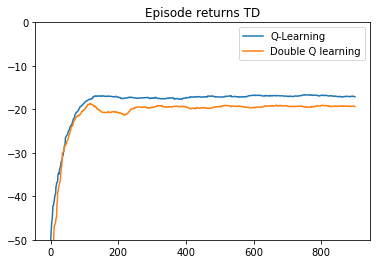

In [25]:
env = WindyGridworldEnv()

Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 1000)

Q = np.zeros((env.nS, 2, env.nA))
policy = EpsilonGreedyPolicyDoubleQ(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 1000)

def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

n = 100
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.gca().set_ylim([-50, 0])
plt.show()

## 2. Blackjack

/home/roel/anaconda3/envs/rlcourse/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 12545.15it/s]


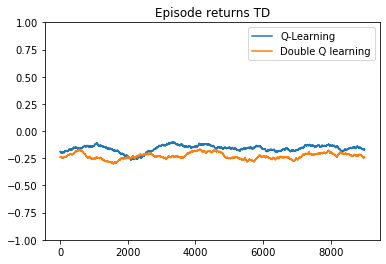

In [26]:
env = gym.make('Blackjack-v0')
# single q
Q = np.zeros([env.observation_space.spaces[0].n * env.observation_space.spaces[1].n * env.observation_space.spaces[2].n, env.action_space.n])
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 10000)

# double q
Q = np.zeros(([env.observation_space.spaces[0].n * env.observation_space.spaces[1].n * env.observation_space.spaces[2].n, 2, env.action_space.n]))
policy = EpsilonGreedyPolicyDoubleQ(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 10000)

n = 1000
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.gca().set_ylim([-1, 1])
plt.show()


## 3. 

  0%|                                                | 0/100000 [00:00<?, ?it/s]

[[ 0.05936937 -0.00687936  0.02912093 -0.06499397 -0.15476782  0.0295182
  -0.04716553  0.09394193  0.01748726 -0.04043412  0.02670425  0.04816595
   0.02490093  0.03775772  0.01422334 -0.09355421 -0.07547701 -0.02866093
  -0.02309035 -0.00829258  0.02915697 -0.04866596  0.03965763 -0.00935106
  -0.04095008  0.07203311 -0.03097685 -0.09833113 -0.00532972  0.05205229
   0.08229039  0.02764278  0.07397421 -0.03475341  0.02932473  0.00127476
  -0.06659084  0.09602103]]


100%|█████████████████████████████████| 100000/100000 [00:59<00:00, 1683.00it/s]


[[[-38.35603499 -38.22172889 -38.10908893 -38.09941725 -38.07098162
   -38.14673451 -38.14781527 -38.11974504 -38.13229534 -38.17036225
   -38.13993676 -38.15480927 -38.09909398 -38.0753106  -38.18918314
   -38.17201035 -38.11232082 -38.21984248 -38.13135624 -38.24163787
   -38.07472313 -38.05445276 -38.06771158 -38.13655974 -38.14530144
   -38.2738611  -38.24033835 -38.0930265  -38.11601672 -38.12734815
   -38.14509992 -38.07699146 -38.17041675 -38.09062861 -38.15707629
   -38.09060756 -38.1846939  -38.14680476]
  [-38.03170963 -38.15658163 -38.26502481 -38.27019475 -38.30161301
   -38.22656863 -38.22307737 -38.25344745 -38.23783252 -38.19975939
   -38.22965515 -38.22245758 -38.2717926  -38.29770083 -38.18836314
   -38.20073637 -38.26088927 -38.14893882 -38.24906156 -38.12636896
   -38.29859853 -38.31950726 -38.30520051 -38.24922982 -38.22990728
   -38.10341899 -38.12865777 -38.27744315 -38.2609898  -38.24157128
   -38.22535889 -38.29307606 -38.20040199 -38.28705943 -38.21167386
   -3

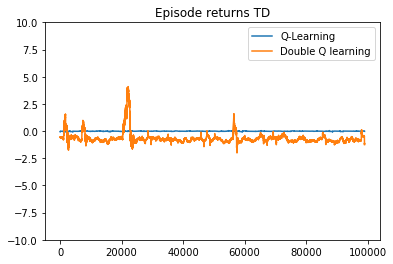

In [27]:
env = gym.make('Roulette-v0')
# single q
Q = np.zeros([env.observation_space.n, env.action_space.n])
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 100000, alpha=0.01)
print(Q_q_learning)
# double q
Q = np.zeros(([env.observation_space.n, 2, env.action_space.n]))
policy = EpsilonGreedyPolicyDoubleQ(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 100000, alpha=0.01)
print(Q_double_q_learning)
n = 1000
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.gca().set_ylim([-10, 10])
plt.show()


In [28]:

def multiple_runs(env, Q, num_episodes, num_seeds, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    returns = []
    lengths = []
    for i in range(num_seeds):
        np.random.seed(i)
        Q_init = np.copy(Q)
        if len(Q.shape) == 3:
            policy = EpsilonGreedyPolicyDoubleQ(Q_init, epsilon=alpha)
            Q_trained, (episode_lengths, episode_returns) = double_q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        else:
            policy = EpsilonGreedyPolicy(Q_init, epsilon=alpha)
            Q_trained, (episode_lengths, episode_returns) = q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        returns.append(episode_returns)
        lengths.append(episode_returns)
    return np.array(lengths), np.array(returns)

def plot_mean_std(X, n, label):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    plt.plot(running_mean(mu, n), label=label)
    plt.fill_between(np.arange(len(running_mean(mu, n))), running_mean(mu+sigma, n), running_mean(mu-sigma, n), alpha=0.5)

            
        
    

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 869.06it/s]


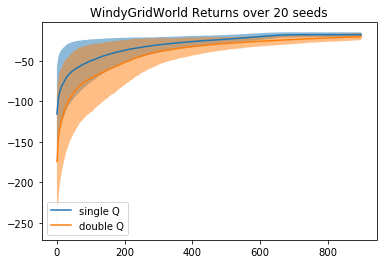

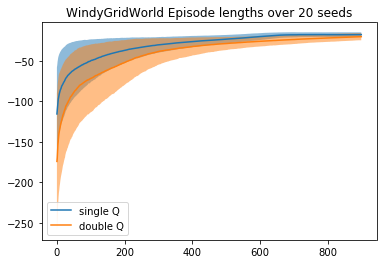

In [29]:
env = WindyGridworldEnv()
# single q init
Q_init_single = np.zeros((env.nS, env.nA))
# double q init
Q_init_double = np.zeros((env.nS, 2, env.nA))

num_seeds = 20
num_episodes = 1000
single_q_lengths, single_q_returns = multiple_runs(env, Q_init_single, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)
double_q_lengths, double_q_returns = multiple_runs(env, Q_init_double, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)

plt.title(f'WindyGridWorld Returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, 100, "single Q")
plot_mean_std(double_q_returns, 100, "double Q")
plt.legend()
plt.show()

plt.title(f'WindyGridWorld Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, 100, "single Q")
plot_mean_std(double_q_lengths, 100, "double Q")
plt.legend()
plt.show()


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1407.66it/s]


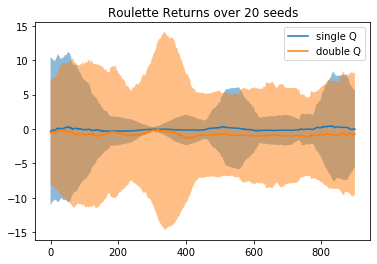

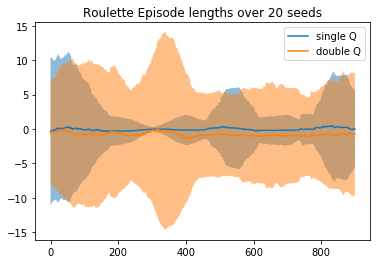

In [30]:
env = gym.make('Roulette-v0')
# single q init
Q_init_single = np.zeros([env.observation_space.n, env.action_space.n])
# double q init
Q_init_double = np.zeros(([env.observation_space.n, 2, env.action_space.n]))

num_seeds = 20
num_episodes = 1000
single_q_lengths, single_q_returns = multiple_runs(env, Q_init_single, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)
double_q_lengths, double_q_returns = multiple_runs(env, Q_init_double, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)

plt.title(f'Roulette Returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, 100, "single Q")
plot_mean_std(double_q_returns, 100, "double Q")
plt.legend()
plt.show()

plt.title(f'Roulette Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, 100, "single Q")
plot_mean_std(double_q_lengths, 100, "double Q")
plt.legend()
plt.show()


100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2176.98it/s]


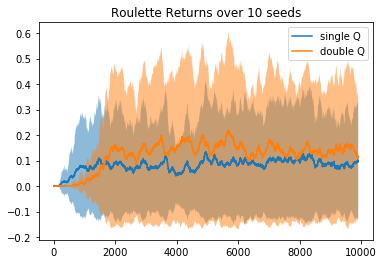

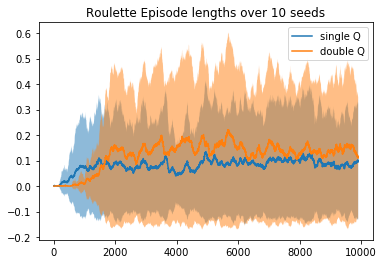

In [38]:
env = gym.make('FrozenLake-v0')
# single q init
Q_init_single = np.zeros([env.observation_space.n, env.action_space.n])
# double q init
Q_init_double = np.zeros(([env.observation_space.n, 2, env.action_space.n]))

num_seeds = 10
num_episodes = 10000
single_q_lengths, single_q_returns = multiple_runs(env, Q_init_single, num_episodes, num_seeds, alpha=0.2, epsilon=0.3)
double_q_lengths, double_q_returns = multiple_runs(env, Q_init_double, num_episodes, num_seeds, alpha=0.2, epsilon=0.3)

plt.title(f'FrozenLake Returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, 100, "single Q")
plot_mean_std(double_q_returns, 100, "double Q")
plt.legend()
plt.show()

plt.title(f'FrozenLake Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, 100, "single Q")
plot_mean_std(double_q_lengths, 100, "double Q")
plt.legend()
plt.show()
